In [3]:
%load_ext autoreload
%autoreload 2

import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, "src")

from pandas import DataFrame
from analytics.metrics.metric import MetricCalculator
from analytics.metrics.time import TimeMetrics
from spec.enums import MainTableColumns as Cols
from spec.spec_definition import PS2Versions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from database.config import PS2DataConfig

spec = PS2Versions.v1_0.load()

# data_config = PS2DataConfig.from_yaml("sample_data_configs/cwo_s19.yaml", spec)
data_config = PS2DataConfig.from_yaml("sample_data_configs/edwards2021.yaml", spec)


In [35]:
from analytics.ps2_dataset import PS2Dataset

dataset = PS2Dataset(spec, data_config)

In [36]:
from analytics.ps2_dataset import Preprocessor
import pandas as pd

class TimeStampToDateTimePreprocessor(Preprocessor):
    """
    Preprocessor that converts the ClientTimestamp column to datetime.
    """

    def apply(self, dataset: PS2Dataset, main_table: DataFrame) -> DataFrame:
        main_table[Cols.ClientTimestamp] = pd.to_datetime(main_table[Cols.ClientTimestamp], unit='ms', utc=True)
        main_table.sort_values(by=[Cols.ClientTimestamp, Cols.EventID], inplace=True)
        return main_table

dataset.main_table_preprocessors.insert(0, TimeStampToDateTimePreprocessor())

In [37]:
# TODO: Add timezone preprocessor to the dataset

main_table = dataset.get_main_table()
main_table.head()

,EventID,SubjectID,AssignmentID,CodeStateSection,EventType,SourceLocation,EditType,InsertText,DeleteText,X-Metadata,ClientTimestamp,ToolInstances,CodeStateID,X-Compilable
1063827,1063827,Student30,Assign6,task1.py,File.Edit,0.0,Insert,# @@@@@@@@@@@@@@@@@@\n# CS1400 - 001\n# Assign...,NaN,NaN,2021-10-08 23:04:57.177000+00:00,PC;PP 1.1.10,NaN,1
1063828,1063828,Student30,Assign6,task1.py,File.Edit,51.0,Insert,\n,NaN,NaN,2021-10-08 23:04:58.077000+00:00,PC;PP 1.1.10,NaN,1
1063829,1063829,Student30,Assign6,task1.py,X-Action,NaN,NaN,NaN,NaN,Backspace,2021-10-08 23:05:00.285000+00:00,PC;PP 1.1.10,NaN,1
1063830,1063830,Student30,Assign6,task1.py,File.Edit,50.0,Delete,NaN,?,NaN,2021-10-08 23:05:00.359000+00:00,PC;PP 1.1.10,NaN,1
1063831,1063831,Student30,Assign6,task1.py,X-Action,NaN,NaN,NaN,NaN,Backspace,2021-10-08 23:05:00.435000+00:00,PC;PP 1.1.10,NaN,1


In [38]:
main_table.ClientTimestamp.iloc[0]

Timestamp('2021-10-08 23:04:57.177000+0000', tz='UTC')

In [39]:
student_subset = main_table[Cols.SubjectID].unique()[:50]
mt_subset = main_table[main_table[Cols.SubjectID].isin(student_subset)]

<Axes: ylabel='Frequency'>

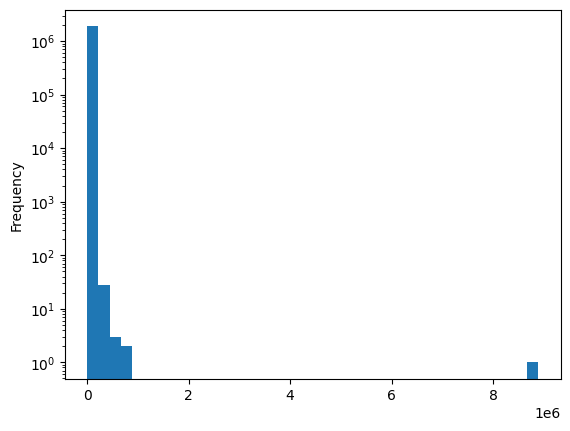

In [40]:
from analytics.metrics.time import TimeMetrics

# CWO
# problem_id_col = Cols.ProblemID
# timestamp_col = Cols.ServerTimestamp

problem_id_col = Cols.AssignmentID
timestamp_col = Cols.ClientTimestamp

diffs = TimeMetrics.get_all_diffs(mt_subset, timestamp_col, [Cols.SubjectID, problem_id_col])
diffs.DeltaSeconds[diffs.DeltaSeconds > 0].plot.hist(bins=40, log=True)

In [41]:
TimeMetrics.get_positive_diff_quantiles(mt_subset, timestamp_col, [Cols.SubjectID, problem_id_col])

# Seems like 5 minutes (90th+ percentile) is a good cutoff for time spent on a problem between submissions
# 30m does seem to suggest that the student is not working on the problem

0.00          0.001
0.25          0.007
0.50          0.080
0.75          0.273
0.80          0.424
0.85          0.710
0.90          1.403
0.95          4.048
0.96          5.746
0.97          9.017
0.98         16.452
0.99         41.805
1.00    8889102.134
Name: DeltaSeconds, dtype: float64

In [42]:
# CWO
# time_metrics = TimeMetrics(5*60, 30 * 60, True, Cols.ServerTimestamp)

# Edwards 2021
time_metrics = TimeMetrics(30, 3 * 60, True, Cols.ClientTimestamp)

# time_metrics.test_calculation(mt_subset, [Cols.SubjectID, Cols.ProblemID])

result = main_table.groupby([Cols.SubjectID, problem_id_col]).apply(lambda x: time_metrics.calculate(x))
result

C:\Users\twprice\AppData\Local\Temp\ipykernel_18180\4101552682.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = main_table.groupby([Cols.SubjectID, problem_id_col]).apply(lambda x: time_metrics.calculate(x))


ActiveTime   IdleTime  TotalTime  \
SubjectID AssignmentID                                     
Student1  Assign10         908.052   2487.099   3395.151   
          Assign12        1585.459   1008.333   2593.792   
          Assign13        2045.757   2598.539   4644.296   
          Assign6         4070.056   3961.911   8031.967   
          Assign7         2824.284   2617.328   5441.612   
...                            ...        ...        ...   
Student9  Assign13         992.713   2005.665   2998.378   
          Assign6         7755.096   5634.013  13389.109   
          Assign7        14471.102   8300.890  22771.992   
          Assign8         6107.274   7163.666  13270.940   
          Assign9        16533.303  11029.517  27562.820   

                        ActiveTimeAfterCorrect  #Breaks  \
SubjectID AssignmentID                                    
Student1  Assign10                           0       14   
          Assign12                           0        5   
          Assign13                           0       19   
          Assign6                            0       22   
          Assign7                            0       18   
...                                        ...      ...   
Student9  Assign13                           0       15   
          Assign6                            0       11   
          Assign7                            0       28   
          Assign8                            0       21   
          Assign9                            0       33   

                                              StartTime FirstCorrectTime  \
SubjectID AssignmentID                                                     
Student1  Assign10     2021-11-12 06:00:34.375000+00:00             None   
          Assign12     2021-12-03 22:30:21.931000+00:00             None   
          Assign13     2021-12-10 17:44:58.869000+00:00             None   
          Assign6      2021-10-18 04:36:30.335000+00:00             None   
          Assign7      2021-10-20 05:51:20.838000+00:00             None   
...                                                 ...              ...   
Student9  Assign13     2021-12-08 07:18:31.529000+00:00             None   
          Assign6      2021-10-18 20:57:40.382000+00:00             None   
          Assign7      2021-10-20 17:35:38.487000+00:00             None   
          Assign8      2021-10-28 18:28:23.074000+00:00             None   
          Assign9      2021-11-03 00:01:11.611000+00:00             None   

                                                EndTime  
SubjectID AssignmentID                                   
Student1  Assign10     2021-11-13 03:30:53.391000+00:00  
          Assign12     2021-12-04 03:59:52.547000+00:00  
          Assign13     2021-12-11 01:17:27.294000+00:00  
          Assign6      2021-10-19 05:53:30.843000+00:00  
          Assign7      2021-10-22 05:46:11.557000+00:00  
...                                                 ...  
Student9  Assign13     2021-12-10 08:57:44.974000+00:00  
          Assign6      2021-10-19 05:50:29.925000+00:00  
          Assign7      2021-10-23 03:23:32.405000+00:00  
          Assign8      2021-10-30 00:16:25.388000+00:00  
          Assign9      2021-11-06 05:36:43.281000+00:00  

[262 rows x 8 columns]

In [44]:
result.describe()

,ActiveTime,IdleTime,TotalTime,ActiveTimeAfterCorrect,#Breaks
count,262.000000,262.000000,262.000000,262.0,262.000000
mean,4726.221863,4869.673305,9595.895168,0.0,22.194656
std,3511.808735,3159.892507,6301.479472,0.0,14.789075
min,2.785000,0.000000,2.785000,0.0,1.000000
25%,2234.519750,2532.143500,5272.033750,0.0,11.000000
50%,4068.577500,4440.209500,8542.743000,0.0,19.000000
75%,6374.244250,6543.017750,12734.744250,0.0,31.750000
max,25022.086000,22182.491000,42719.173000,0.0,80.000000
